In [30]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import joblib
import math
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

In [31]:
# 计算距离
def Span(data):
    R = 6371.393  # 地球半径，单位为千米  ##851,881   800,809   131,150
    for i in range(800,899):###################################################################          133
        # A地  
        jingduA, weiduA = data.loc[i-1,['经度','纬度']]
        # B地  
        jingduB, weiduB = data.loc[i,['经度','纬度']]

        # 将经纬度转换为弧度  
        latA, lonA = math.radians(weiduA), math.radians(jingduA)  
        latB, lonB = math.radians(weiduB), math.radians(jingduB)  

        # 哈弗辛公式  
        dlat = latB - latA  
        dlon = lonB - lonA  
        a = math.sin(dlat/2)**2 + math.cos(latA) * math.cos(latB) * math.sin(dlon/2)**2  
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))  

        distance = R * c * 1000  # 距离，单位为米  
        # 转换为米  
        data['距离差'][i]=distance
    return data

In [32]:
# 定义一个函数来提取指定位置的字段内容
def extract_field(text, position):
    # 根据逗号分隔字符串
    fields = text.split(',')
    
    # 确保位置有效
    if position < len(fields):
        return fields[position]
    else:
        return None

In [33]:
# 假设 data 是一个 Pandas DataFrame，包含经纬度、速度、方向和运动状态的序列数据
# 数据集格式：[经度1, 纬度1, 速度1, 方向1, 运动状态1, 经度2, 纬度2, 速度2, 方向2, 运动状态2]
# val_data = pd.read_excel('D:/data/trackHistory1_zao.xlsx')
# val_data=val_data.iloc[130:150]  #150####################################################     133

val_data = pd.read_excel('D:/data/0280/0280原始数据.xlsx')#850:881   799:809  
val_data=val_data.iloc[799:899]  #150####################################################     133

test=val_data[['经度','纬度']]



#将文字类型转换为数字类型
val_data['活动状态'] = val_data['设备状态'].apply(lambda x: extract_field(x, 3))#4
val_data['活动状态']=val_data['活动状态'].map({'静止':0,'运动':1})
val_data['定位方式']=val_data['定位方式'].map({'GPS有效定位':0,'GPS无效定位':1,'LBS':1})


val_data=val_data[['定位时间','经度','纬度','活动状态','定位方式','方向','速度']]
# print(val_data)

val_data['前活动状态'] = val_data['活动状态'].shift(+1)
val_data['前定位方式'] = val_data['定位方式'].shift(+1)
val_data['前方向'] = val_data['方向'].shift(+1)
val_data['前速度'] = val_data['速度'].shift(+1)
val_data['前经度'] = val_data['经度'].shift(+1)
val_data['前纬度'] = val_data['纬度'].shift(+1)

# 计算两点间距
val_data['距离差']=np.NaN
val_data=Span(val_data)

# val_data = val_data.dropna()  # 删除缺失值

# 处理时间列
val_data['定位时间'] = pd.to_datetime(val_data['定位时间'])  # 确保时间列是datetime格式
# 计算时间差
val_data['时间差']=val_data['定位时间'].diff().dt.total_seconds()
val_data['时间差']=val_data['时间差'].fillna(0).astype(int)#将时间差转换为以秒为单位的int类型

val_data['year'] = val_data['定位时间'].dt.year
val_data['month'] = val_data['定位时间'].dt.month
val_data['day'] = val_data['定位时间'].dt.day
val_data['hour'] = val_data['定位时间'].dt.hour
val_data['minute'] = val_data['定位时间'].dt.minute
val_data['second'] = val_data['定位时间'].dt.second

#计算加速度
#由 V=V0+at    a=(V-V0)/t
val_data['加速度']=(val_data['速度']-val_data['前速度'])/val_data['时间差']

val_data = val_data.dropna()  # 删除缺失值

# 删除原时间列
val_data = val_data.drop(columns=['定位时间'])
#     print(val_data)
# # 提取特征和标签  #
val_features = ['year', 'month', 'day', 'hour', 'minute', 'second', '方向','活动状态', '定位方式','速度','前经度', '前纬度','前活动状态','前定位方式','前方向','前速度','距离差','时间差','加速度']
val_labels = ['经度','纬度']

val_X = val_data[val_features].values
val_y = val_data[val_labels].values


# 归一化特征和标签
val_scaler_X = MinMaxScaler()
val_scaler_y = MinMaxScaler()

val_X_scaled = val_scaler_X.fit_transform(val_X)
val_y_scaled = val_scaler_y.fit_transform(val_y)

# #标准化
# scaler_X = StandardScaler()
# scaler_X.fit(X)
# X_scaled = scaler_X.fit_transform(X)
# scaler_y = StandardScaler()
# scaler_y.fit(y)
# y_scaled = scaler_y.transform(y)

# 创建时间序列数据
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 1  # 根据需求设置时间步长
val_X_seq, val_y_seq = create_dataset(val_X_scaled, val_y_scaled, time_steps)

####################################################################################

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3144\2002714984.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['距离差'][i]=distance
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3144\2002714984.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['距离差'][i]=distance
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3144\2002714984.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['距离差'][i]=distance
C:\U

In [36]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size,dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# 加载模型
input_size = 19  # 特征数
hidden_size = 256  #256
num_layers = 1 #LSTM层数
output_size = 2  # 经纬度
dropout=0.5

model = LSTMModel(input_size, hidden_size, num_layers, output_size,dropout)
model.load_state_dict(torch.load('D:/data/0280/lstm_model_3.pth',weights_only=True))
model.eval()

# 创建示例输入数据
# example_data = np.random.rand(1, 10, input_size).astype(np.float32)
input_tensor = torch.tensor(val_X_seq, dtype=torch.float32)

# 进行预测
with torch.no_grad():
    prediction = model(input_tensor)

# 反归一化
y_pred = prediction.numpy()
y_pred = val_scaler_y.inverse_transform(y_pred)

# 输出经纬度
# print("Predicted Latitude and Longitude:", y_pred)
# y_pred


val_data[['预测经度','预测纬度','定位点和预测点距离差']]=np.NaN
# print(val_data.shape)
# print(val_data.columns)
val_data.iloc[1:,21:23]=y_pred#################################################要改
val_data=val_data.iloc[1:]
# val_data


test=val_y
test=test[1:]
test.shape


import math  

R = 6371.393  # 地球半径，单位为千米  
for i in range(0,97):##############################################     1
    # A地  
    jingduA, weiduA = y_pred[i]
    # B地  
    jingduB, weiduB = test[i]

    # 将经纬度转换为弧度  
    latA, lonA = math.radians(weiduA), math.radians(jingduA)  
    latB, lonB = math.radians(weiduB), math.radians(jingduB)  

    # 哈弗辛公式  
    dlat = latB - latA  
    dlon = lonB - lonA  
    a = math.sin(dlat/2)**2 + math.cos(latA) * math.cos(latB) * math.sin(dlon/2)**2  
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))  

    distance = R * c * 1000  # 距离，单位为米  
    # 转换为米  
    val_data['定位点和预测点距离差'][131+i+1]=distance
#     print(distance)

E:\anaconda\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3144\625649971.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['定位点和预测点距离差'][131+i+1]=distance
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3144\625649971.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['定位点和预测点距离差'][131+i+1]=distance
C:\Users\Ad

In [37]:
val_data

,经度,纬度,活动状态,定位方式,方向,速度,前活动状态,前定位方式,前方向,前速度,...,year,month,day,hour,minute,second,加速度,预测经度,预测纬度,定位点和预测点距离差
801,113.814408,22.695658,1,0,60,29.8,1.0,0.0,61.0,18.8,...,2024,7,29,20,7,45,0.366667,113.818970,22.697378,NaN
802,113.816664,22.696856,1,0,62,33.9,1.0,0.0,60.0,29.8,...,2024,7,29,20,8,15,0.136667,113.821907,22.699141,NaN
803,113.818000,22.697534,1,0,61,13.7,1.0,0.0,62.0,33.9,...,2024,7,29,20,8,46,-0.651613,113.819504,22.698669,NaN
804,113.818864,22.697958,1,0,71,11.1,1.0,0.0,61.0,13.7,...,2024,7,29,20,9,16,-0.086667,113.823265,22.699751,NaN
805,113.820000,22.698478,1,0,65,17.4,1.0,0.0,71.0,11.1,...,2024,7,29,20,9,46,0.210000,113.826370,22.701624,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,113.943560,22.687988,1,0,272,0.0,1.0,0.0,272.0,0.0,...,2024,7,29,20,54,11,0.000000,113.939659,22.689075,NaN
895,113.943688,22.687976,1,0,83,0.0,1.0,0.0,272.0,0.0,...,2024,7,29,20,54,41,0.000000,113.939796,22.689081,NaN
896,113.943688,22.687976,1,0,83,0.0,1.0,0.0,83.0,0.0,...,2024,7,29,20,55,11,0.000000,113.936737,22.689598,NaN
897,113.943720,22.688700,1,0,42,8.9,1.0,0.0,83.0,0.0,...,2024,7,29,20,55,42,0.287097,113.933304,22.690855,NaN


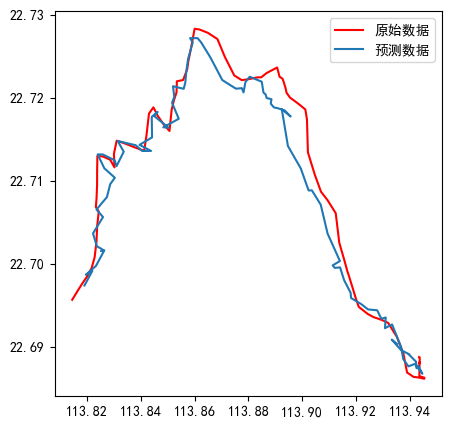

In [38]:
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

x= val_data[['经度']]
y =val_data[['纬度']]
plt.figure(figsize=(5, 5),dpi=100)
plt.plot(x, y,'-r',label='原始数据')
plt.plot(val_data[['预测经度']],val_data[['预测纬度']],label='预测数据')
plt.legend()
plt.show()

In [11]:
# val_data[['预测经度','预测纬度','定位点和预测点距离差']]=np.NaN
# val_data.iloc[1:,21:23]=y_pred#################################################要改
# val_data=val_data.iloc[1:]
# val_data

In [26]:
val_y.shape

(99, 2)

In [27]:
test=val_y
test=test[1:]
test.shape

(98, 2)

In [28]:
import math  
  
R = 6371.393  # 地球半径，单位为千米  
for i in range(0,18):##############################################     1
    # A地  
    jingduA, weiduA = y_pred[i]
    # B地  
    jingduB, weiduB = test[i]

    # 将经纬度转换为弧度  
    latA, lonA = math.radians(weiduA), math.radians(jingduA)  
    latB, lonB = math.radians(weiduB), math.radians(jingduB)  

    # 哈弗辛公式  
    dlat = latB - latA  
    dlon = lonB - lonA  
    a = math.sin(dlat/2)**2 + math.cos(latA) * math.cos(latB) * math.sin(dlon/2)**2  
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))  

    distance = R * c * 1000  # 距离，单位为米  
    # 转换为米  
    val_data['定位点和预测点距离差'][131+i+1]=distance
    print(distance)

260.4558727474719
171.51814386183216
186.3257371198449
137.15194192887316
394.71062754729934
186.09935771545491
48.96979980027112
352.9466403696884
387.08939445632035
1185.239296757056
233.96418844242336
763.9582442212121
338.1682765051299
274.2610465841578
515.4510313505879
266.07643666574404
1185.5943376675764
999.7895453298862


C:\Users\Administrator\AppData\Local\Temp\ipykernel_3144\57686152.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['定位点和预测点距离差'][131+i+1]=distance
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3144\57686152.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['定位点和预测点距离差'][131+i+1]=distance
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3144\57686152.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [29]:
# # 计算距离
# def Span(data):
#     R = 6371.393  # 地球半径，单位为千米  ##851,881  131,150
#     for i in range(131,150):###################################################################          133
#         # A地  
#         jingduA, weiduA = data.loc[i-1,['经度','纬度']]
#         # B地  
#         jingduB, weiduB = data.loc[i,['经度','纬度']]

#         # 将经纬度转换为弧度  
#         latA, lonA = math.radians(weiduA), math.radians(jingduA)  
#         latB, lonB = math.radians(weiduB), math.radians(jingduB)  

#         # 哈弗辛公式  
#         dlat = latB - latA  
#         dlon = lonB - lonA  
#         a = math.sin(dlat/2)**2 + math.cos(latA) * math.cos(latB) * math.sin(dlon/2)**2  
#         c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))  

#         distance = R * c * 1000  # 距离，单位为米  
#         # 转换为米  
#         data['距离差'][i]=distance
#     return data
# count=0
# for i in range(0,42):
#     # 假设 data 是一个 Pandas DataFrame，包含经纬度、速度、方向和运动状态的序列数据
#     # 数据集格式：[经度1, 纬度1, 速度1, 方向1, 运动状态1, 经度2, 纬度2, 速度2, 方向2, 运动状态2]
#     val_data = pd.read_excel('D:/data/trackHistory1_zao.xlsx')
#     val_data=val_data.iloc[130:150]  #150####################################################     133

#     # val_data = pd.read_excel('D:/data/0280/0280原始数据.xlsx')
#     # val_data=val_data.iloc[850:881]  #150####################################################     133

#     test=val_data[['经度','纬度']]



#     #将文字类型转换为数字类型
#     val_data['活动状态'] = val_data['设备状态'].apply(lambda x: extract_field(x, 4))
#     val_data['活动状态']=val_data['活动状态'].map({'静止':0,'运动':1})
#     val_data['定位方式']=val_data['定位方式'].map({'GPS有效定位':0,'GPS无效定位':1,'LBS':1})


#     val_data=val_data[['定位时间','经度','纬度','活动状态','定位方式','方向','速度']]
#     # print(val_data)

#     val_data['前活动状态'] = val_data['活动状态'].shift(+1)
#     val_data['前定位方式'] = val_data['定位方式'].shift(+1)
#     val_data['前方向'] = val_data['方向'].shift(+1)
#     val_data['前速度'] = val_data['速度'].shift(+1)
#     val_data['前经度'] = val_data['经度'].shift(+1)
#     val_data['前纬度'] = val_data['纬度'].shift(+1)

#     # 计算两点间距
#     val_data['距离差']=np.NaN
#     val_data=Span(val_data)

#     # val_data = val_data.dropna()  # 删除缺失值

#     # 处理时间列
#     val_data['定位时间'] = pd.to_datetime(val_data['定位时间'])  # 确保时间列是datetime格式
#     # 计算时间差
#     val_data['时间差']=val_data['定位时间'].diff().dt.total_seconds()
#     val_data['时间差']=val_data['时间差'].fillna(0).astype(int)#将时间差转换为以秒为单位的int类型

#     val_data['year'] = val_data['定位时间'].dt.year
#     val_data['month'] = val_data['定位时间'].dt.month
#     val_data['day'] = val_data['定位时间'].dt.day
#     val_data['hour'] = val_data['定位时间'].dt.hour
#     val_data['minute'] = val_data['定位时间'].dt.minute
#     val_data['second'] = val_data['定位时间'].dt.second

#     #计算加速度
#     #由 V=V0+at    a=(V-V0)/t
#     val_data['加速度']=(val_data['速度']-val_data['前速度'])/val_data['时间差']

#     val_data = val_data.dropna()  # 删除缺失值

#     # 删除原时间列
#     val_data = val_data.drop(columns=['定位时间'])
# #     print(val_data)
#     # # 提取特征和标签
#     val_features = ['year', 'month', 'day', 'hour', 'minute', 'second', '方向','活动状态', '定位方式','速度','前经度', '前纬度','前活动状态','前定位方式','前方向','前速度','距离差','时间差','加速度']
#     val_labels = ['经度','纬度']

#     val_X = val_data[val_features].values
#     val_y = val_data[val_labels].values


#     # 归一化特征和标签
#     val_scaler_X = MinMaxScaler()
#     val_scaler_y = MinMaxScaler()

#     val_X_scaled = val_scaler_X.fit_transform(val_X)
#     val_y_scaled = val_scaler_y.fit_transform(val_y)

#     # #标准化
#     # scaler_X = StandardScaler()
#     # scaler_X.fit(X)
#     # X_scaled = scaler_X.fit_transform(X)
#     # scaler_y = StandardScaler()
#     # scaler_y.fit(y)
#     # y_scaled = scaler_y.transform(y)

#     # 创建时间序列数据
#     def create_dataset(X, y, time_steps=1):
#         Xs, ys = [], []
#         for i in range(len(X) - time_steps):
#             Xs.append(X[i:i + time_steps])
#             ys.append(y[i + time_steps])
#         return np.array(Xs), np.array(ys)

#     time_steps = 1  # 根据需求设置时间步长
#     val_X_seq, val_y_seq = create_dataset(val_X_scaled, val_y_scaled, time_steps)

# ####################################################################################



#     # 定义LSTM模型
#     class LSTMModel(nn.Module):
#         def __init__(self, input_size, hidden_size, num_layers, output_size,dropout):
#             super(LSTMModel, self).__init__()
#             self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#             self.fc = nn.Linear(hidden_size, output_size)

#         def forward(self, x):
#             out, _ = self.lstm(x)
#             out = self.fc(out[:, -1, :])
#             return out

#     # 加载模型
#     input_size = 19  # 特征数
#     hidden_size = 256  #256
#     num_layers = 1 #LSTM层数
#     output_size = 2  # 经纬度
#     dropout=0.5

#     model = LSTMModel(input_size, hidden_size, num_layers, output_size,dropout)
#     model.load_state_dict(torch.load(f'D:/data/399071350587_1/lstm_model_{count+1}.pth',weights_only=True))
#     model.eval()

#     # 创建示例输入数据
#     # example_data = np.random.rand(1, 10, input_size).astype(np.float32)
#     input_tensor = torch.tensor(val_X_seq, dtype=torch.float32)

#     # 进行预测
#     with torch.no_grad():
#         prediction = model(input_tensor)

#     # 反归一化
#     y_pred = prediction.numpy()
#     y_pred = val_scaler_y.inverse_transform(y_pred)

#     # 输出经纬度
#     # print("Predicted Latitude and Longitude:", y_pred)
#     # y_pred


#     val_data[['预测经度','预测纬度','定位点和预测点距离差']]=np.NaN
#     val_data.iloc[1:,21:23]=y_pred#################################################要改
#     val_data=val_data.iloc[1:]
#     # val_data


#     test=val_y
#     test=test[1:]
#     test.shape


#     import math  

#     R = 6371.393  # 地球半径，单位为千米  
#     for i in range(0,18):##############################################     1
#         # A地  
#         jingduA, weiduA = y_pred[i]
#         # B地  
#         jingduB, weiduB = test[i]

#         # 将经纬度转换为弧度  
#         latA, lonA = math.radians(weiduA), math.radians(jingduA)  
#         latB, lonB = math.radians(weiduB), math.radians(jingduB)  

#         # 哈弗辛公式  
#         dlat = latB - latA  
#         dlon = lonB - lonA  
#         a = math.sin(dlat/2)**2 + math.cos(latA) * math.cos(latB) * math.sin(dlon/2)**2  
#         c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))  

#         distance = R * c * 1000  # 距离，单位为米  
#         # 转换为米  
#         val_data['定位点和预测点距离差'][131+i+1]=distance
#         print(distance)
#     count=count+1

In [11]:
# val_data.to_excel('D:/data/测试结果.xlsx')

In [12]:
# def is_within_range(angle1, angle2, range_degrees=120):
#     """
#     判断 angle2 是否在 angle1 的 ±range_degrees 范围内。
#     参数:
#     angle1, angle2: 输入的角度值，范围是0到360度。
#     range_degrees: 范围值，默认是120度。
#     返回:
#     如果 angle2 在 angle1 的 ±range_degrees 范围内，则返回 True；否则返回 False。
#     """
#     # 处理范围的最小值和最大值
#     lower_bound = (angle1 - range_degrees) % 360
#     upper_bound = (angle1 + range_degrees) % 360

#     # 判断角度是否在范围内
#     if lower_bound < upper_bound:
#         # 范围没有跨越0度
#         return lower_bound <= angle2 <= upper_bound
#     else:
#         # 范围跨越了0度
#         return angle2 >= lower_bound or angle2 <= upper_bound

# # 示例用法
# angle1 = 349
# angle2 = 211

# result = is_within_range(angle1, angle2)
# print(f"角度 {angle2} 是否在角度 {angle1} 的 ±120° 范围内？ {result}")

In [13]:
# for i in range(0,1):####################################################################################          1
#     if val_data['定位方式'][131+i+1]==0:  #判断定位是否有效
#         if is_within_range(val_data['方向'][131+i], val_data['方向'][131+i+1]):   #判断方向是否有效
#             if val_data['距离差'][131+i+1]<200:  #判断定位点是否有效
#                 print('当前坐标点有效')
#             else:
#                 print('当前坐标无效')
#                 val_data['经度'][131+i+1]=val_data['预测经度'][131+i+1]
#                 val_data['纬度'][131+i+1]=val_data['预测纬度'][131+i+1]
#         else:
#             print('当前坐标无效')
#             val_data['经度'][131+i+1]=val_data['预测经度'][131+i+1]
#             val_data['纬度'][131+i+1]=val_data['预测纬度'][131+i+1]
#     else:
#         print('当前坐标无效')
#         val_data['经度'][131+i+1]=val_data['预测经度'][131+i+1]
#         val_data['纬度'][131+i+1]=val_data['预测纬度'][131+i+1]
# val_data